In [66]:
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import matplotlib.pyplot as plt

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.25.1


In [2]:
data_path = "../1_annotation_tools/data/datasets_to_check/combined_datasets/combined_datasets.csv"

In [3]:
df = pd.read_csv(data_path).fillna("")

In [39]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [43]:
#df[(df.cmpl_anim == "anim") & (df.cmpl_constr == "vc")]

In [5]:
# Create a new column containing the level "book_scroll"

df["book_scroll"] = df["book"].astype(str) + "_" + df["scroll"].astype(str)

In [6]:
# Candidate covariates; we keep the ones that exist in df
candidate_covars = ["cmpl_complex", "cmpl_anim", "cmpl_det", "cmpl_def", "cmpl_indiv", "motion_type"]

In [44]:
# Drop rows with "no complement", "reconstructed", "min excluded", spatial argument other than goal
df_model = df.copy()
df_model = df_model.loc[df_model["cmpl_constr"] != "no complement"].copy()
df_model = df_model.loc[df_model["comments"] != "min excluded"].copy()
df_model = df_model.loc[df_model["comments"] != "reconstructed"].copy()
df_model = df_model.loc[df_model["comments"] != "reconstructed?"].copy()
df_model = df_model.loc[df_model["spatial_arg_type"] == "goal"].copy()
df_model = df_model.loc[df_model["motion_type"] != "posture/not motion"].copy()
df_model = df_model.loc[df_model["motion_type"] != "vertical"].copy()

In [74]:
set(df_model.preposition_1)

{'',
 ' >L',
 '<D',
 '<L',
 '<L ',
 '<M',
 '>L',
 '>L ',
 '>L BJN/',
 '>L PNH/',
 '>T==',
 '>YL/',
 'B',
 'BJN/',
 'BMW',
 'L',
 'L PNH/',
 'NGD/',
 'QDM/',
 'TXT/'}

In [45]:
# Modify the cmpl_constr with multiple prepositions into "prep"

df_model.loc[df_model["cmpl_constr"].isin(["prep + prep", "prep + prep + prep", "prep + prep + prep + prep"]), "cmpl_constr"] = "prep"

In [46]:
# Ensure key columns exist
for col in ["cmpl_constr", "book_scroll", "lex"]:
    assert col in df_model.columns, f"Missing column: {col}"

In [47]:
# --- Encode outcome as categorical (no special reference; sum-to-zero)
df_model["cmpl_constr"] = df_model["cmpl_constr"].astype("category")
class_labels = df_model["cmpl_constr"].cat.categories.tolist()
K = len(class_labels)
y = df_model["cmpl_constr"].cat.codes.values  # 0..K-1

In [48]:
set(y)

{np.int8(0), np.int8(1), np.int8(2), np.int8(3)}

In [49]:
class_labels

['dir-he', 'prep', 'prep + dir-he', 'vc']

In [50]:
# --- Encode grouping factors as categorical indices
df_model["book_scroll"] = df_model["book_scroll"].astype("category")
df_model["lex"] = df_model["lex"].astype("category")

In [51]:
book_labels = df_model["book_scroll"].cat.categories.tolist()
verb_labels = df_model["lex"].cat.categories.tolist()
B = len(book_labels)
V = len(verb_labels)

In [52]:
book_idx = df_model["book_scroll"].cat.codes.values.astype("int32")
verb_idx = df_model["lex"].cat.codes.values.astype("int32")

In [53]:
# --- Build design matrix X for covariates
have_covars = [c for c in candidate_covars if c in df_model.columns]
X_df_parts = []

for c in have_covars:
    s = df_model[c]
    # treat as categorical/boolean
    s = s.astype("category")
    dummies = pd.get_dummies(s, prefix=c, drop_first=True)  # baseline within this covariate
    if dummies.shape[1] > 0:
        X_df_parts.append(dummies.astype(float))

In [54]:
if len(X_df_parts) > 0:
    X_df = pd.concat(X_df_parts, axis=1)
    # Ensure no all-NA or all-constant columns slipped in
    X_df = X_df.loc[:, X_df.apply(lambda col: col.nunique(dropna=True) > 1)]
else:
    # If no covariates present, create a zero-column matrix safely
    X_df = pd.DataFrame(index=df_model.index)

In [67]:
#X_df

In [56]:
[name for name in X_df.columns if name.startswith("cmpl_indiv")]

['cmpl_indiv_adv',
 'cmpl_indiv_nmpr',
 'cmpl_indiv_ppde',
 'cmpl_indiv_ppin',
 'cmpl_indiv_prsf',
 'cmpl_indiv_ptcl',
 'cmpl_indiv_subs']

In [57]:
feature_names = X_df.columns.tolist()
P = len(feature_names)

X = X_df.to_numpy(dtype=float)

N = len(df_model)

print(f"N={N}, K={K} classes, B={B} book_scroll levels, V={V} verb levels, P={P} features")

N=4233, K=4 classes, B=159 book_scroll levels, V=61 verb levels, P=14 features


In [58]:
# ===== 2) Build & fit the PyMC model (sum-to-zero logits) =====
coords = {
    "obs": np.arange(N),
    "class": class_labels,
    "book": book_labels,
    "verb": verb_labels,
    "feature": feature_names,
}

In [59]:
feature_names

['cmpl_complex_simple',
 'cmpl_anim_anim',
 'cmpl_anim_anim inanim',
 'cmpl_anim_inanim',
 'cmpl_det_und',
 'cmpl_indiv_adv',
 'cmpl_indiv_nmpr',
 'cmpl_indiv_ppde',
 'cmpl_indiv_ppin',
 'cmpl_indiv_prsf',
 'cmpl_indiv_ptcl',
 'cmpl_indiv_subs',
 'motion_type_fictive',
 'motion_type_vertical']

In [60]:
with pm.Model(coords=coords) as model:
    # Data containers (easy swapping for PPC / newdata later)
    y_data       = pm.Data("y_data", y, dims="obs")
    book_idx_dat = pm.Data("book_idx", book_idx, dims="obs")
    verb_idx_dat = pm.Data("verb_idx", verb_idx, dims="obs")
    X_dat        = pm.Data("X", X, dims=("obs","feature")) if P > 0 else None

    # --- Intercepts for ALL K classes (no reference class)
    alpha = pm.Normal("alpha", 0.0, 2.5, dims="class")

    # --- Fixed effects per class (shape: P x K)
    beta = pm.Normal("beta", 0.0, 1.5, dims=("feature","class"))

    # --- Random intercepts: book_scroll (non-centered), per class ==> effect of the book
    sigma_book = pm.HalfNormal("sigma_book", 1.0, dims="class") # how books impact classes (cmpl_constr)
    z_book = pm.Normal("z_book", 0.0, 1.0, dims=("class","book")) # how each book impacts classes (cmpl_constr)
    book_eff = pm.Deterministic("book_eff", z_book * sigma_book[:, None], dims=("class","book"))  # K x B
    
    # sigma_book attenuate the effect of z_book; if, for one class, books have no impact or little impact 
    # but one particular book could have an impact
    # the effect of the book in particular is attenuated
    # it attenuates the effect of a specific book that could be random or due to another cause
    # book_eff is the effect of each book on the classes (cmpl_constr)

    # --- Random intercepts: verb (non-centered), per class ==> effect of the verb
    sigma_verb = pm.HalfNormal("sigma_verb", 1.0, dims="class")
    z_verb     = pm.Normal("z_verb", 0.0, 1.0, dims=("class","verb"))
    verb_eff   = pm.Deterministic("verb_eff", z_verb * sigma_verb[:, None], dims=("class","verb"))  # K x V

    # --- Linear predictor for all K classes
    # shapes:
    #   alpha          : (K,) -> (N,K) after broadcasting
    #   book_eff.T[idx]: (N,K)
    #   verb_eff.T[idx]: (N,K)
    #   X @ beta       : (N,P)@(P,K) -> (N,K), or zeros if P==0

    # This is where the crossed factor choice is implemented (contri and eta)
    # the book_scrolls effect and the verb effect are included at the same time
    # they don't depend on each other (e.g. the book does not change the verb)
    # every observation is classified independently by both factors
    
    book_contrib = pt.transpose(book_eff)[book_idx_dat, :]   # (N, K)
    verb_contrib = pt.transpose(verb_eff)[verb_idx_dat, :]   # (N, K)
    fixed_contrib = pt.dot(X_dat, beta) if P > 0 else pt.zeros((N, K))

    # book_contrib is the contribution o the book on each observation
    # fixed_contrib is the effect of the features on each observation

    # Add alpha (random intercept for the classes) to the contributions

    eta = alpha[None, :] + book_contrib + verb_contrib + fixed_contrib  # (N, K)

    # --- Sum-to-zero constraint across classes for each observation (identifiability)
    eta_centered = eta - pt.mean(eta, axis=1, keepdims=True)  # (N, K)
    # ==> more readable, has no impact on the results probabilities

    # --- Softmax probabilities and likelihood
    p = pm.math.softmax(eta_centered, axis=1)  # (N, K)
    y_obs = pm.Categorical("y_obs", p=p, observed=y_data, dims="obs")
    # ==> transforms logits into probabilities

    # --- Sampling
    idata = pm.sample(
        draws=1000, # I reduced from 2000 to 1000 because of memory issues
        tune=1000, # same here
        chains=4,
        target_accept=0.9,
        random_seed=42,
        cores=None,  # let PyMC decide
    )

    # Posterior predictive
    ppc = pm.sample_posterior_predictive(idata, random_seed=42)

Initializing NUTS using jitter+adapt_diag...
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma_book, z_book, sigma_verb, z_verb]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 697 seconds.
Sampling: [y_obs]


Output()

In [61]:
# ===== 3) Basic diagnostics & examples =====
az.summary(idata, var_names=["alpha","sigma_book","sigma_verb"], round_to=2)

# mean column: the posterior mean of the parameter, expected value under the posterior distribution
# mean tells the average posterior estimate of the variation for the book or verb for each class

# sigma_books: how much book_scrolls differ from each other 
# in their baseline preference for that outcome class

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[dir-he],-2.24,1.65,-5.37,0.87,0.02,0.02,5018.71,3510.90,1.00
alpha[prep],4.32,1.58,1.35,7.27,0.02,0.02,4610.25,2993.83,1.00
alpha[prep + dir-he],-2.55,1.79,-5.78,0.88,0.02,0.03,5143.33,3252.51,1.00
alpha[vc],0.53,1.61,-2.29,3.66,0.02,0.02,4338.95,3379.27,1.00
sigma_book[dir-he],0.94,0.23,0.51,1.36,0.01,0.00,897.96,1344.92,1.00
sigma_book[prep],0.68,0.20,0.29,1.07,0.01,0.01,569.31,463.78,1.01
sigma_book[prep + dir-he],0.68,0.44,0.00,1.43,0.01,0.01,1714.97,1723.72,1.00
sigma_book[vc],0.79,0.22,0.37,1.22,0.01,0.01,563.09,451.68,1.00
sigma_verb[dir-he],1.01,0.32,0.43,1.64,0.01,0.01,1438.40,1329.38,1.00
sigma_verb[prep],0.73,0.29,0.18,1.33,0.01,0.01,935.53,553.72,1.00


In [65]:
az.summary(idata, var_names=["verb_eff"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"verb_eff[dir-he, <BR]",-0.07,1.04,-2.12,1.91,0.01,0.02,10315.37,2960.52,1.00
"verb_eff[dir-he, <BR[]",0.93,0.55,-0.10,1.92,0.01,0.01,2036.83,2027.60,1.00
"verb_eff[dir-he, <LH]",0.01,1.11,-2.14,2.11,0.01,0.02,7642.49,3001.75,1.00
"verb_eff[dir-he, <LH[]",0.01,0.45,-0.79,0.90,0.01,0.01,2281.86,2908.76,1.00
"verb_eff[dir-he, <WP[]",-0.00,1.07,-1.96,2.08,0.01,0.02,9436.46,2965.46,1.00
"verb_eff[dir-he, <WZ]",-0.07,1.10,-2.02,2.22,0.01,0.03,11787.97,2453.05,1.00
"verb_eff[dir-he, <WZ[]",-0.00,1.05,-1.97,2.06,0.01,0.02,9850.53,2314.56,1.00
"verb_eff[dir-he, >TH[]",-0.02,1.06,-2.09,1.91,0.01,0.02,8746.68,2460.89,1.00
"verb_eff[dir-he, BRX[]",0.02,0.68,-1.21,1.29,0.01,0.01,6678.23,3258.11,1.00
"verb_eff[dir-he, BW>]",-0.34,0.98,-2.18,1.55,0.01,0.02,7022.13,2810.36,1.00


In [62]:
az.summary(idata, var_names=["beta"], round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[cmpl_complex_simple, dir-he]",1.72,0.79,0.28,3.26,0.02,0.01,2470.87,2769.20,1.00
"beta[cmpl_complex_simple, prep]",-0.28,0.78,-1.74,1.21,0.02,0.01,2296.51,2875.87,1.00
"beta[cmpl_complex_simple, prep + dir-he]",-1.45,0.97,-3.36,0.28,0.02,0.01,3522.82,3156.75,1.00
"beta[cmpl_complex_simple, vc]",0.04,0.79,-1.36,1.61,0.02,0.01,2318.27,2849.87,1.00
"beta[cmpl_anim_anim, dir-he]",-1.88,1.24,-4.33,0.31,0.02,0.02,6306.78,3117.55,1.00
"beta[cmpl_anim_anim, prep]",2.57,1.14,0.52,4.73,0.01,0.02,6181.12,3065.91,1.00
"beta[cmpl_anim_anim, prep + dir-he]",-0.58,1.36,-3.09,2.08,0.01,0.02,9089.27,2877.74,1.00
"beta[cmpl_anim_anim, vc]",-0.09,1.18,-2.15,2.27,0.01,0.02,7436.66,2729.37,1.00
"beta[cmpl_anim_anim inanim, dir-he]",-0.04,1.50,-2.86,2.78,0.01,0.03,10648.17,2935.83,1.00
"beta[cmpl_anim_anim inanim, prep]",0.22,1.41,-2.23,3.00,0.01,0.03,9068.89,2550.38,1.00


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

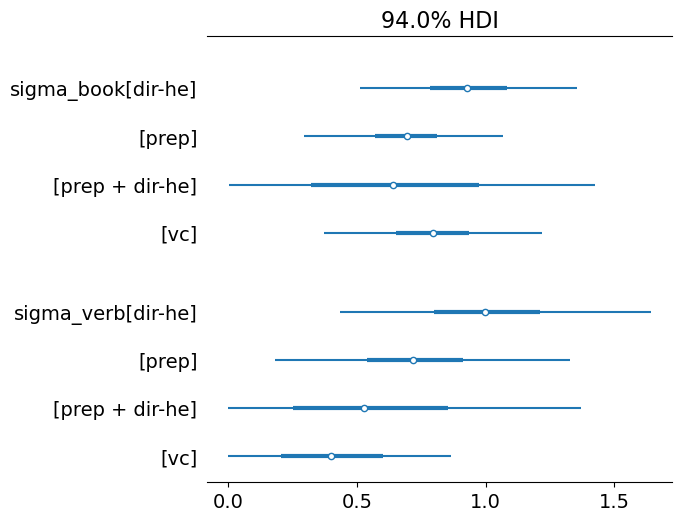

In [63]:
# Check pooling magnitude
az.plot_forest(idata, var_names=["sigma_book","sigma_verb"], combined=True)

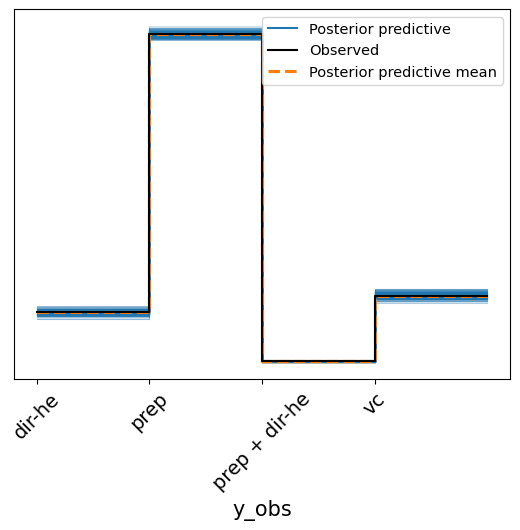

In [68]:
# Posterior predictive check (class frequencies)
az.plot_ppc(ppc, num_pp_samples=200)

plt.xticks(range(len(class_labels)), class_labels, rotation=45)
plt.show()

In [69]:
# ===== 4) (Optional) Helper to predict on new data =====
# Build a function that reuses encodings and preprocessing
def build_X_new(df_new: pd.DataFrame) -> np.ndarray:
    parts = []
    for c in have_covars:
        if c not in df_new.columns:
            # Missing covariate -> treat as baseline (zeros)
            if c in feature_names:  # numeric baseline handled by zeros
                pass
            continue
        s = df_new[c]
        if pd.api.types.is_numeric_dtype(s):
            # Recompute using training mean/sd (we didn't save them above for brevity).
            # For production, store mu/sd used earlier and apply here.
            raise ValueError("To predict with numeric covariates, store mu/sd during training.")
        else:
            s = s.astype("category")
            dummies = pd.get_dummies(s, prefix=c, drop_first=True).astype(float)
            parts.append(dummies)
    X_new = pd.concat(parts, axis=1) if parts else pd.DataFrame(index=df_new.index)
    # Align to training feature order/columns
    X_new = X_new.reindex(columns=feature_names, fill_value=0.0)
    return X_new.to_numpy(dtype=float)

# Example usage for in-sample PPC-style probabilities:
# with model:
#     pm.set_data({"X": X, "book_idx": book_idx, "verb_idx": verb_idx})
#     post = idata.posterior
#     # Compute probabilities p for current data via deterministic graph:
#     # (already included in model; here we'd re-sample p if needed)